# Study generation at different temperatures

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
from model import AttentionModel
from attention import trainer
from dcascore import *
# back to original path (in PLM)
sys.path.pop(0)  # Removes the parent_dir from sys.path
from model import AttentionModel

from plm_hamming_dist import hamming_dist, energy_corr_array
from plm_gen_methods import generate_plm_n_save
from plm_seq_utils import read_tensor_from_txt, set_seed, letters_to_nums, modify_seq

## Calculate J

In [15]:
##############################################################
"""
    Load Q, K, V matrices from jdoms (after training)
"""
set_seed()
H = 64
d= 10
N = 174
n_epochs = 500
loss_type = 'without_J'
family = 'jdoms' #'jdoms_bacteria_train2'
cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/my_project/PLM-gen-DCA/Attention-DCA-main/CODE/AttentionDCA_python/src'
Q_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/Q_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
K_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/K_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
V_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/V_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
H,d,N=Q_1.shape
q=V_1.shape[1]

##############################################################
"""
    Initialize the model and compute couplings J from Q, K, V
""" 
model=AttentionModel(H,d,N,q,Q=Q_1,V=V_1,K=K_1)
torch.sum(model.Q-Q_1)
device = Q_1.device
L = Q_1.shape[-1]
W=attention_heads_from_model(model,Q_1,K_1,V_1)
print(W.shape)

i_indices = torch.arange(L, device=device).unsqueeze(1)
j_indices = torch.arange(L, device=device).unsqueeze(0)
mask = (i_indices != j_indices).float().unsqueeze(0)  # shape (1, L, L)
W = W * mask
    
# Compute Jtens
Jtens = torch.einsum('hri,hab->abri', W, V_1)  # Shape: (q, q, L, L)
q = Jtens.shape[0]
N = Jtens.shape[2]
print(q)
print(N)


torch.Size([64, 63, 63])
21
63


### Check symmetry of Jtens

In [36]:
# Compute the difference between J_ij and J_ji
site_symmetry_diff = Jtens - Jtens.permute(1, 0, 3, 2)  # Swap site i and j

mean_J_abs = torch.mean(torch.abs(Jtens)).item()
print(f"Average magnitude of Jtens: {mean_J_abs:.5f}")

# Option 1: Mean absolute asymmetry across all elements
asymmetry_score = torch.mean(torch.abs(site_symmetry_diff)).item()
print(f"Mean site-wise asymmetry in Jtens: {asymmetry_score:.5f}")

# Option 2: Max absolute asymmetry (worst-case)
max_asym = torch.max(torch.abs(site_symmetry_diff)).item()
print(f"Max site-wise asymmetry: {max_asym:.5f}")

# Option 3: Mean absolute asymmetry across all elements
mean_J_abs = torch.mean(torch.abs(Jtens)).item()
rel_asymmetry = asymmetry_score / mean_J_abs
print(f"Relative mean asymmetry: {rel_asymmetry:.2f}")


Average magnitude of Jtens: 0.04136
Mean site-wise asymmetry in Jtens: 0.05569
Max site-wise asymmetry: 1.23564
Relative mean asymmetry: 1.35


In [22]:
"""
    Generate sequences with PLM initialization from a sequence different betas
"""
init_sequence = 'DYYQVLGVPKDADAKSIKKAFRKLARKYHPDVNPGDKEAERKFKEANEANEVLSDPEKRKKYD'
init_sequence_num = letters_to_nums(init_sequence)
ratio = 0.1
init_sequence_num = modify_seq(init_sequence_num, ratio)
save_dir = "generated_sequences"
N_seqs=30000

betas = [0.01, 0.1, 0.5, 1, 2, 4, 8]
for b in betas:
    save_name = f"gen_seqs_w_init_seq_Ns{N_seqs}_r{ratio}_b{b}"
    generate_plm_n_save(save_dir, save_name, Jtens, N_seqs, init_sequence=init_sequence_num, beta=b)
    print("beta ", b, "saved")

100%|██████████| 30000/30000 [06:49<00:00, 73.29it/s]


Generated sequences (letters): ['YYYWVLGVPKDADAKSIKKAFRKWARKYHPDVNPGDKEAERKFKEANIANEVLLDPEKRFKYD', 'YYYWVLGVPKDADAKSIKKAFRKWGRKYHPDVNPGDKEAERKFKEANIANEVLLDPEKRFKYD', 'YTYWVLGVPKDADAKSIKKAFRKWGRKYHPDVNPGDKEAERKFKEANIANEVLLDPEKRFKYD', 'YTYWVLGVPKDADAKSIKKAFRKMGRKYHPDVNPGDKEAERKFKEANIANEVLLDPEKRFKYD', 'YTYWVLGVPKDADAKSIYKAFRKMGRKYHPDVNPGDKEAERKFKEANIANEVLLDPEKRFKYD']
Generated sequences saved to generated_sequences
beta  0.01 saved


100%|██████████| 30000/30000 [06:55<00:00, 72.24it/s]


Generated sequences (letters): ['PPHS-MMKMYY-GQSCAMFDWQKFDWTCVHSLYHAPYNPFMEVMDWGEPGAFHSWQMQKAMGQ', 'PPHS-MMKMYY-GQSCAMFDWQKFYWTCVHSLYHAPYNPFMEVMDWGEPGAFHSWQMQKAMGQ', 'PPTS-MMKMYY-GQSCAMFDWQKFYWTCVHSLYHAPYNPFMEVMDWGEPGAFHSWQMQKAMGQ', 'PPTS-MMKMYY-GQSCAMFDWQKFYWTCVHSLYHAPYNPFMEVMDWGEPGAFHSWQMQCAMGQ', 'PPTS-MMKMYY-GQSCAMFDWQKFYWTCVHSLYHAPYNPFMEVMDWGEPGAFHSWQMQCAMGQ']
Generated sequences saved to generated_sequences
beta  0.1 saved


100%|██████████| 30000/30000 [06:42<00:00, 74.45it/s]


Generated sequences (letters): ['ETPHQGH-FWKLDGHTAKWTDRITHLQKFCYGLKAPGCIVYIPGSNGMIWQSWCGSSGYSHAY', 'ETPHQGH-FWKLDGHTAKWTDRITHLQKFCYGLKAPGCIVYIPGSNGMIWQSWCGSSGYSHAY', 'ETPHQGH-FWKLGGHTAKWTDRITHLQKFCYGLKAPGCIVYIPGSNGMIWQSWCGSSGYSHAY', 'ETPHQGH-FWKLGGHTAKWTDRITHLQKFCYGLKAPGCIVYIPGSNGMIWQSKCGSSGYSHAY', 'ETPHQGH-FWKLGGHTAKWTDRITHLQKFCYGLKAPGCIVHIPGSNGMIWQSKCGSSGYSHAY']
Generated sequences saved to generated_sequences
beta  0.5 saved


100%|██████████| 30000/30000 [07:09<00:00, 69.91it/s]


Generated sequences (letters): ['FREIWWWYSETHRIRMY-PKKI-QWLIVFFQKEITRCFFKD-FMETCHVLWEESNGFEANWEN', 'FREIWWWYSETHRIRMY-PKKI-QWLIGFFQKEITRCFFKD-FMETCHVLWEESNGFEANWEN', 'FREIWWWYSETHRIRMY-PKKI-QWLIGFFQKEITRCFFKD-FMETCHVLWERSNGFEANWEN', 'FFEIWWWYSETHRIRMY-PKKI-QWLIGFFQKEITRCFFKD-FMETCHVLWERSNGFEANWEN', 'FFEIWWWYSETHRIRMY-PKKI-QWLIGFFQKEITRCFFKD-FMETCHVLWERSNQFEANWEN']
Generated sequences saved to generated_sequences
beta  1 saved


100%|██████████| 30000/30000 [08:09<00:00, 61.24it/s]


Generated sequences (letters): ['DLYALLGVARGATCIEIKKAFHHVARRYHPDQHAGDSDAEDRAKEAMEAYQILSDPEKRQKFD', 'DLYALLGVARGATCIEIKKAFHHVARRFHPDQHAGDSDAEDRAKEAMEAYQILSDPEKRQKFD', 'DLYALLGVARGATCIEIKKAFHAVARRFHPDQHAGDSDAEDRAKEAMEAYQILSDPEKRQKFD', 'DLYALLGVARGASCIEIKKAFHAVARRFHPDQHAGDSDAEDRAKEAMEAYQILSDPEKRQKFD', 'DLYALLGVARGASCIEIKKAFHAVARRFHPDQHAGDSDAEDRAKEAMEAYQILSDPEKRQKFD']
Generated sequences saved to generated_sequences
beta  2 saved


100%|██████████| 30000/30000 [09:56<00:00, 50.29it/s]


Generated sequences (letters): ['DYYEILGVSRDASEDEIKKAYKKLAKKYHPDLNPGDKEAEEKFKEVQEAYEVLSDEQKRSQYD', 'DYYEILGVSRDASEDEIKKAYKKLAKKYHPDLNPGDKEAEEKFKEVQEAYEVLSDEQKRSQYD', 'DYYEILGVSRDASEDEIKKAYKKLAKKYHPDLNPGDKEAEEKFKEVQEAYEVLSDEQKRSQYD', 'DYYEILGVSRDASEDEIKKAYKKLAKKYHPDLNPGDKEAEEKFKEVQEAYEVLSDEQKRSQYD', 'DYYEILGVSRDASEDEIKKAYKKLAKKYHPDLNPGDKEAEEKFKEVQEAYEVLSDEQKRSQYD']
Generated sequences saved to generated_sequences
beta  4 saved


100%|██████████| 30000/30000 [08:29<00:00, 58.87it/s]


Generated sequences (letters): ['DYYEILGVSKNASQDEIKKAYRKLAKKYHPDLNPGDKEAEEKFKEINEAYEVLSDEEKRKKYD', 'DYYEILGVSKNASQDEIKKAYRKLAKKYHPDLNPGDKEAEEKFKEINEAYEVLSDEEKRKKYD', 'DYYEILGVSKNASQDEIKKAYRKLAKKYHPDLNPGDKEAEEKFKEINEAYEVLSDEEKRKKYD', 'DYYEILGVSKNASQDEIKKAYRKLAKKYHPDLNPGDKEAEEKFKEINEAYEVLSDEEKRKKYD', 'DYYEILGVSKNASQDEIKKAYRKLAKKYHPDLNPGDKEAEEKFKEINEAYEVLSDEEKRKKYD']
Generated sequences saved to generated_sequences
beta  8 saved


In [23]:

#----------- Load sequences with different betas -------------
cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/my_project/PLM-gen-DCA/Attention-DCA-main'
#cwd='C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\git_test\PLM-gen-DCA\Attention-DCA-main'

betas = [0.01, 0.1, 0.5, 1, 2, 4, 8]
correlations_means = []
correlations_array = []  # Will become a 2D array: len(betas) x len(correlation steps)

for b in betas:
    filename = f'gen_seqs_w_init_seq_Ns30000_r0.1_b{b}'
    output_file = cwd + f'/CODE/AttentionDCA_python/src/PLM/generated_sequences/{filename}.npy'
    gen_sequences = np.load(output_file)

    initial_sequence = gen_sequences[0]
    hamming_distances = []
    for seq in gen_sequences:
        distance = hamming_dist(initial_sequence, seq)
        hamming_distances.append(distance)
    hamming_distances = np.array(hamming_distances)
    result = energy_corr_array(hamming_distances, int(len(hamming_distances)/5))
    correlations_array.append(result)
    correlation = np.mean(result[-1000:])
    correlations_means.append(correlation)
correlations_means = np.array(correlations_means)
correlations_array = np.array(correlations_array)

print(np.shape(correlations_array))

(7, 6000)


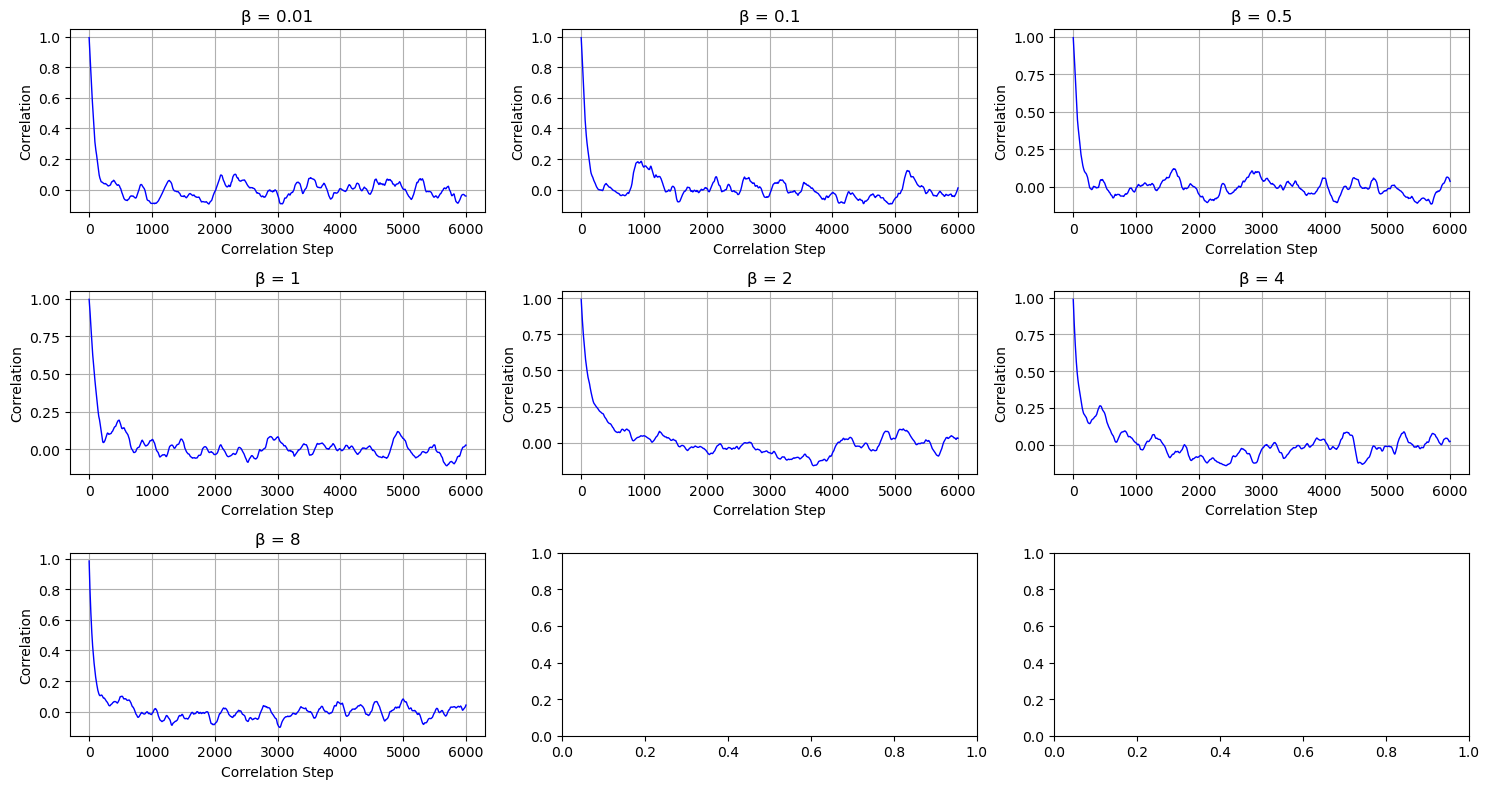

In [24]:
#----------- Plot the correlations for each temperature -------------
fig, axes = plt.subplots(3, 3, figsize=(15, 8))  # 2 rows x 3 columns
axes = axes.flatten()  # So we can index them easily with a single loop

for i, b in enumerate(betas):
    ax = axes[i]
    #ax.plot(correlations_array[i], marker='o', linestyle='-')
    ax.plot(correlations_array[i],marker='', linestyle='-', linewidth=1, color='b')
    ax.set_title(f"β = {b}")
    ax.set_xlabel("Correlation Step")
    ax.set_ylabel("Correlation")
    ax.grid(True)

plt.tight_layout()
#plt.savefig(cwd + '/CODE/AttentionDCA_python/src/PLM/generated_sequences/beta_correlations_grid.pdf')
plt.show()

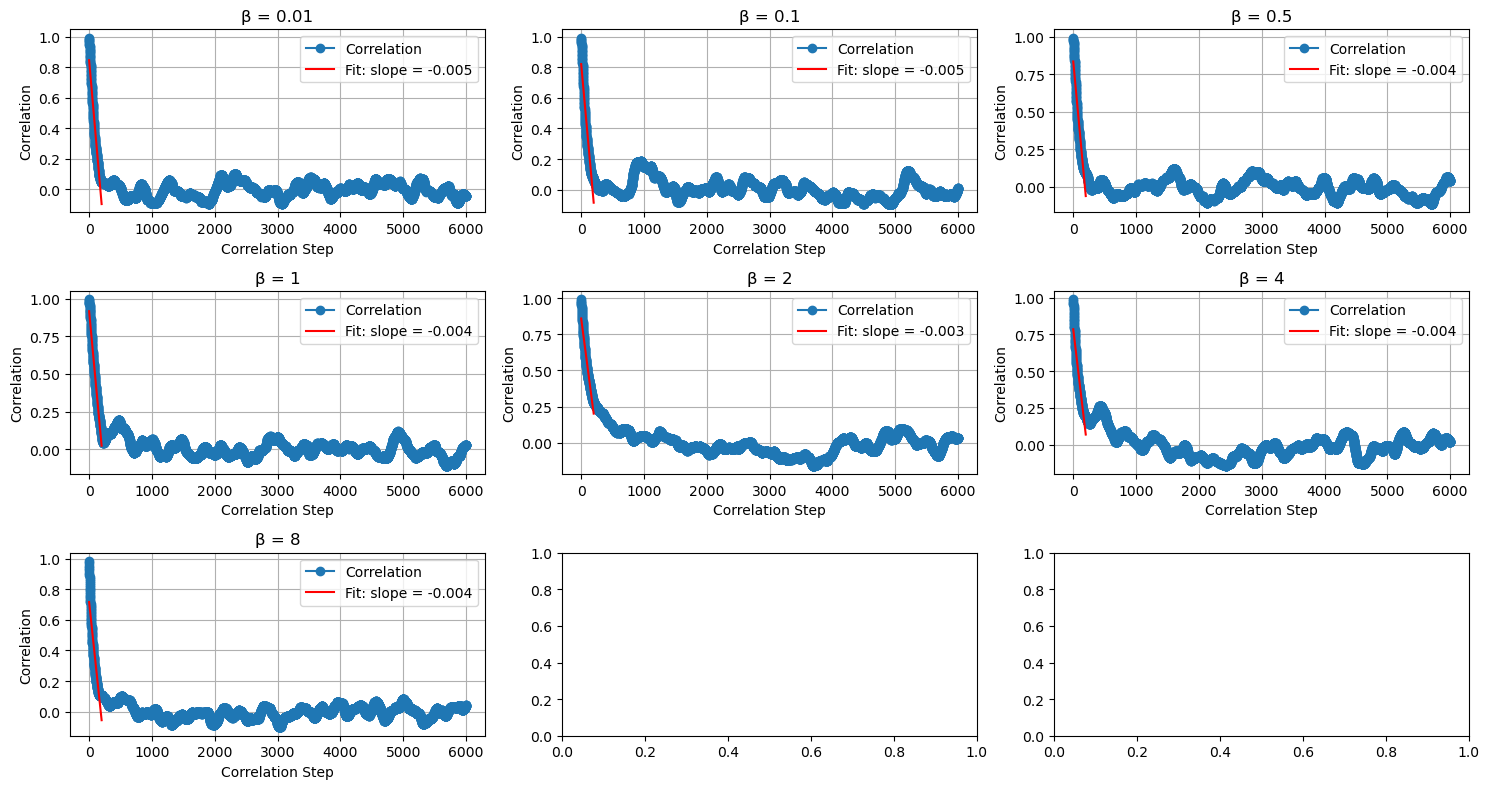

Slope for β = 0.01: -0.005
Slope for β = 0.1: -0.005
Slope for β = 0.5: -0.004
Slope for β = 1: -0.004
Slope for β = 2: -0.003
Slope for β = 4: -0.004
Slope for β = 8: -0.004


In [29]:
from scipy.stats import linregress
slopes = []  # To store slopes for each beta

# Plot the correlations and calculate the slope
fig, axes = plt.subplots(3, 3, figsize=(15, 8))  # 2 rows x 3 columns
axes = axes.flatten()  # So we can index them easily with a single loop

for i, b in enumerate(betas):
    ax = axes[i]
    cor_values = correlations_array[i]
    
    # Select first 1000 values for the linear fit
    range = 200
    x_vals = np.arange(range)  # X values for linear fit (steps)
    y_vals = cor_values[:range]  # First 1000 correlation values
    
    # Perform linear fit: y = mx + c, extract the slope (m)
    slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)
    
    # Store the slope for this beta
    slopes.append(slope)
    
    # Plot the correlation curve and linear fit
    ax.plot(cor_values, marker='o', linestyle='-', label="Correlation")
    ax.plot(x_vals, slope * x_vals + intercept, color='r', label=f"Fit: slope = {slope:.3f}")
    ax.set_title(f"β = {b}")
    ax.set_xlabel("Correlation Step")
    ax.set_ylabel("Correlation")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
# plt.savefig(cwd + '/CODE/AttentionDCA_python/src/PLM/generated_sequences/beta_correlations_grid.pdf')
plt.show()

# Print the slopes for each beta
for i, b in enumerate(betas):
    print(f"Slope for β = {b}: {slopes[i]:.3f}")

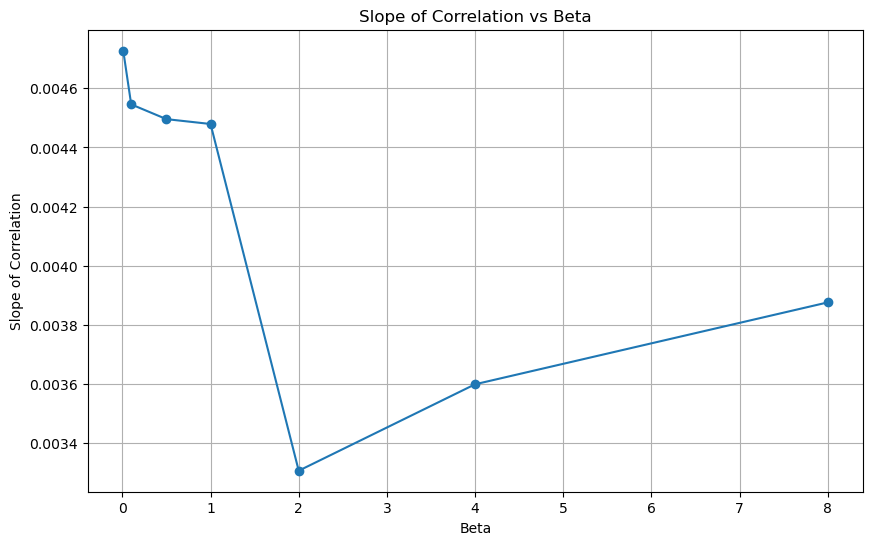

In [32]:
# Plot the slopes
plt.figure(figsize=(10, 6))
plt.plot(betas, np.abs(slopes), marker='o', linestyle='-') 
plt.xlabel("Beta")
plt.ylabel("Slope of Correlation")
plt.title("Slope of Correlation vs Beta")
plt.grid(True)

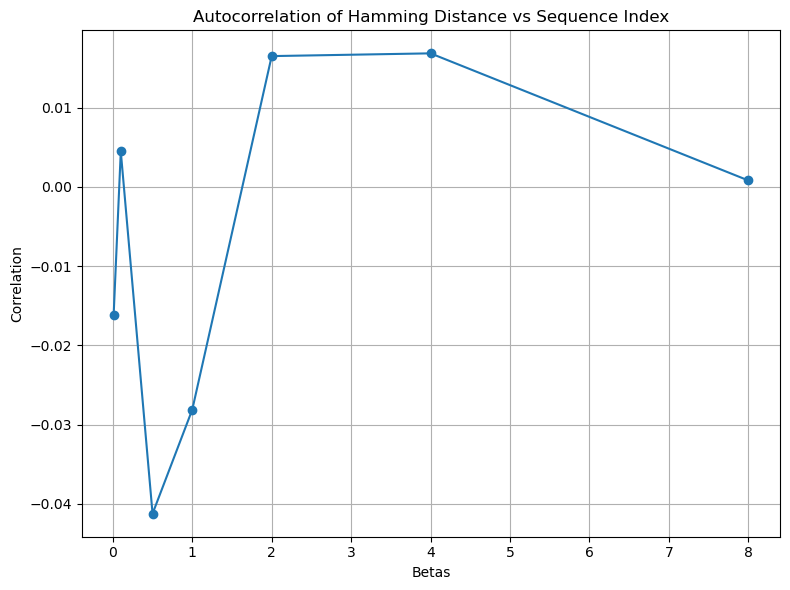

In [33]:
#------------- Plot correlations vs temperature -------------------

cwd = os.getcwd()
save_path = cwd + '/results/Temperatures'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(betas, correlations_means, marker='o', linestyle='-')
plt.title("Autocorrelation of Hamming Distance vs Sequence Index")
plt.xlabel("Betas")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.savefig(save_path + f'/temperature_correlation.pdf')

## PCAs

<>:19: SyntaxWarning: invalid escape sequence '\C'
<>:19: SyntaxWarning: invalid escape sequence '\C'
/var/folders/dv/fpf7xq8j6yzfxjs7g9c_bbyc0000gn/T/ipykernel_40979/2582853255.py:19: SyntaxWarning: invalid escape sequence '\C'
  fig_file=cwd + f'\CODE\AttentionDCA_python\src\PLM\PCA_fig\PCA_beta_{beta}'


Total sequences read: 14502
Sequences after filtering: 14502
(63, 14502)
Removing duplicate sequences...
Done: 14502 -> 14502 sequences after removing duplicates.


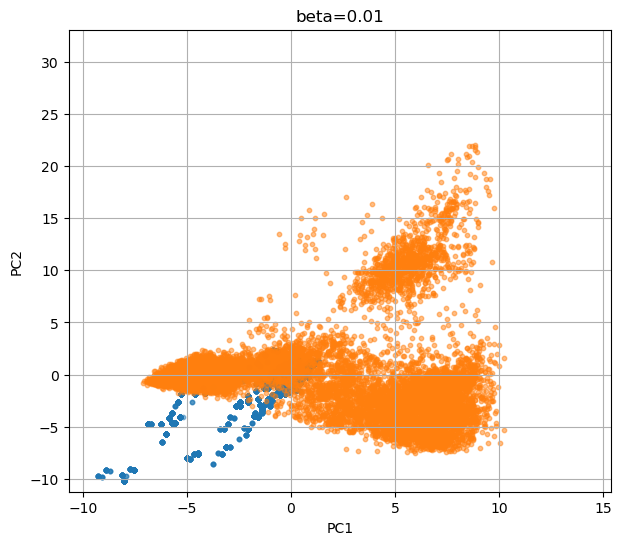

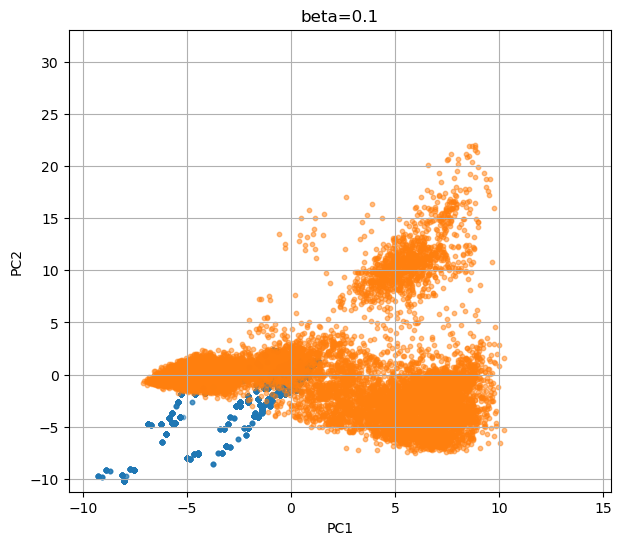

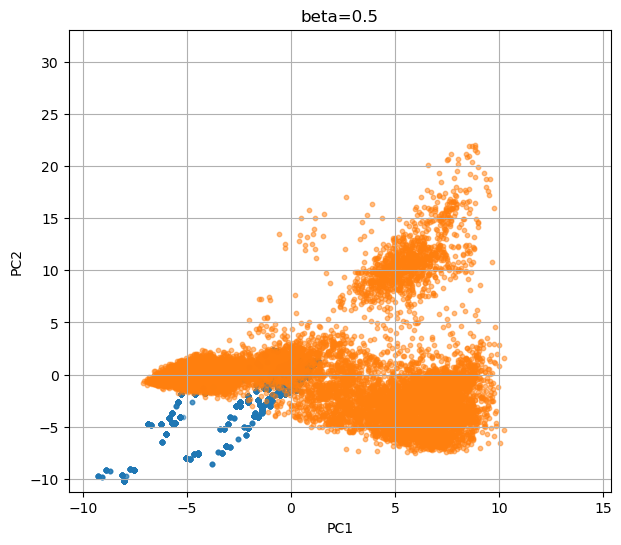

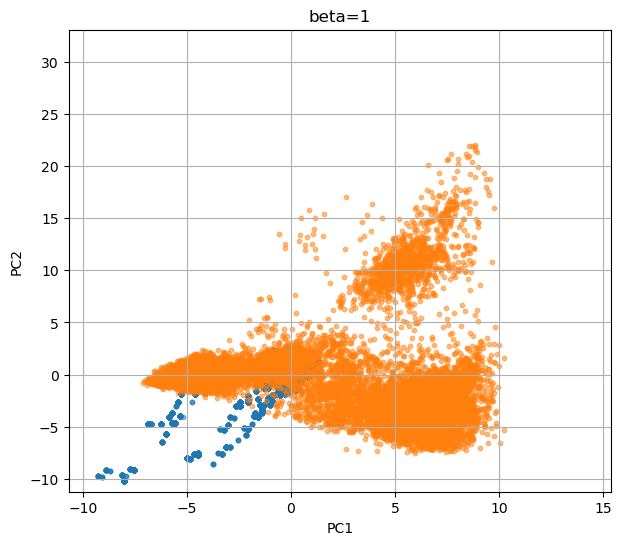

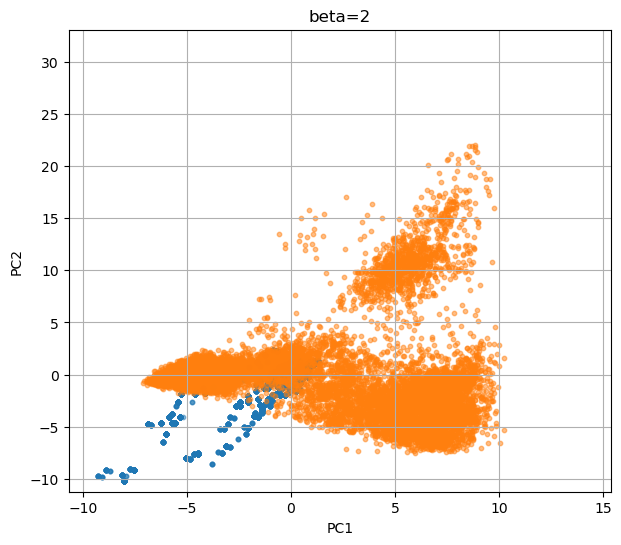

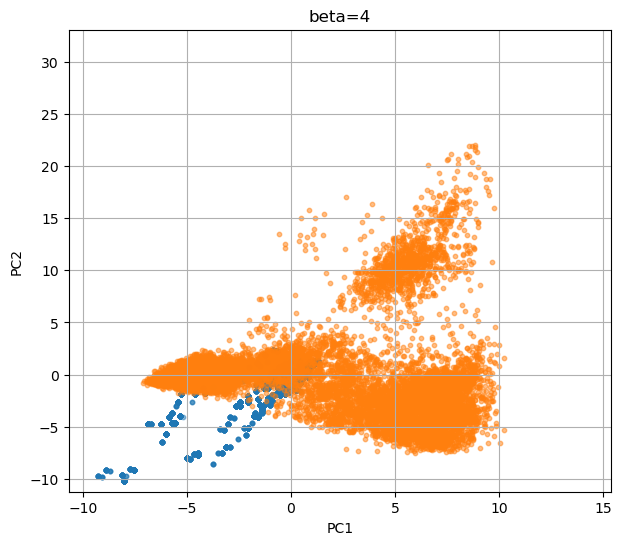

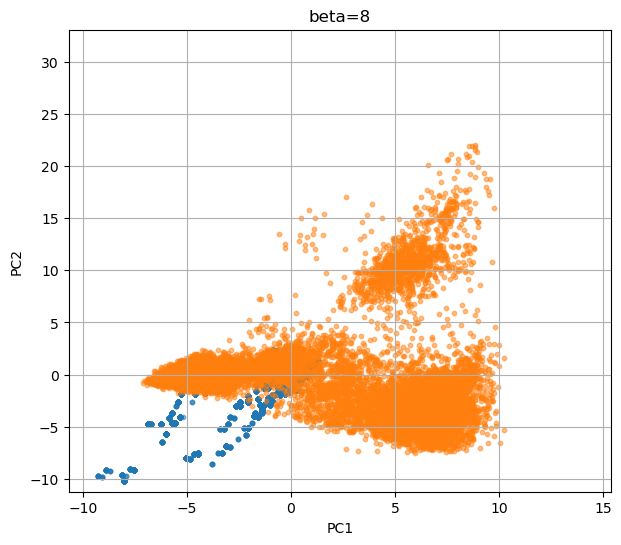

In [35]:
from utils import read_fasta_alignment, remove_duplicate_sequences
from plm_hamming_dist import vectorized_hamming_distance
from sampling_test import plot_pca_of_sequences
#file_test_data=r"C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\git_test\PLM-gen-DCA\Attention-DCA-main\CODE\DataAttentionDCA\jdoms\jdoms_bacteria_train2.fasta"
file_test_data = "/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/my_project/PLM-gen-DCA/Attention-DCA-main/CODE/DataAttentionDCA/jdoms/jdoms_bacteria_train2.fasta"
seq_data_test = read_fasta_alignment(file_test_data,0.8)
mean_ham_dist = []
print(seq_data_test.shape)
seq_data_test_filtered,_ = remove_duplicate_sequences(seq_data_test)
seq_data_test_filtered = seq_data_test_filtered.T

cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/my_project/PLM-gen-DCA/Attention-DCA-main'
for beta in betas:
    filename = f'gen_seqs_w_init_seq_Ns30000_r0.1_b{b}'
    output_file = cwd + f'/CODE/AttentionDCA_python/src/PLM/generated_sequences/{filename}.npy'
    gen_sequences = np.load(output_file)

    mean_ham_dist.append(np.mean(vectorized_hamming_distance(gen_sequences[10000:],seq_data_test_filtered)))
    fig_file=cwd + f'\CODE\AttentionDCA_python\src\PLM\PCA_fig\PCA_beta_{beta}'
    plot_pca_of_sequences(gen_sequences,title=f"beta={beta}",comparison_data=seq_data_test_filtered)